# Lab Exercise #3 


In [12]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [13]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [14]:
# For easy modification
height = 128
width = 128
image_size = (height, width)
batch_size = 32
epochs = 50


## Loading the Dataset

In [15]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
    #shuffle=True,
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
    #shuffle=True,
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

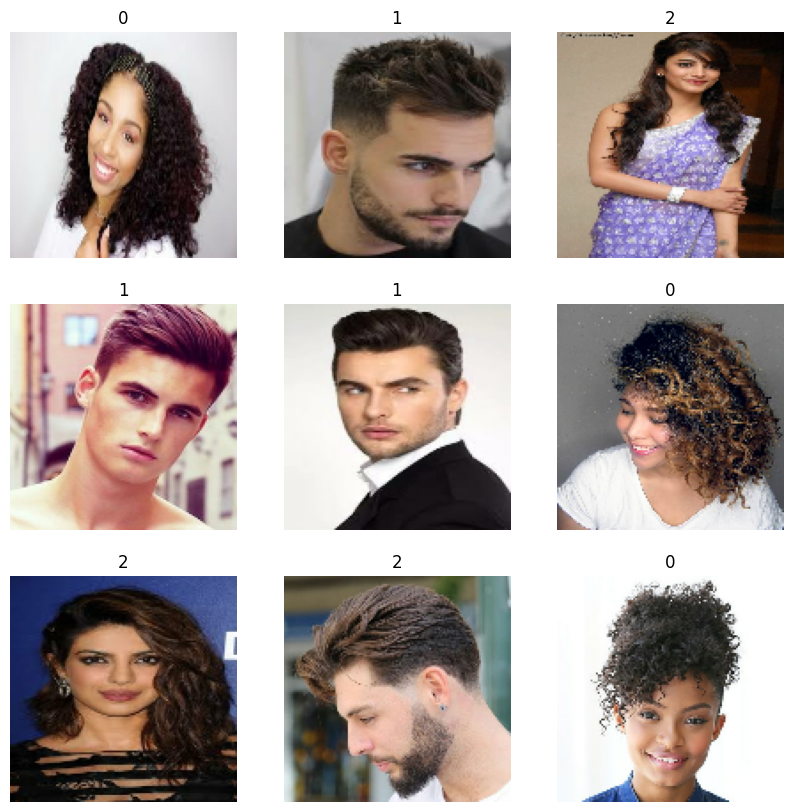

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Model Architecture

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

model = keras.Sequential()

model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu',  dilation_rate=1))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu',  dilation_rate=1))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu',  dilation_rate=1))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='valid', activation='relu',  dilation_rate=1))

model.add(layers.GlobalMaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation="softmax"))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,795 (1.03 MB)

 Trainable params: 269,763 (1.03 MB)

 Non-trainable params: 32 (128.00 B)

### Model Training

In [18]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate reduction
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.3630 - loss: 1.1698 - val_accuracy: 0.3487 - val_loss: 1.0981 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.3680 - loss: 1.0923 - val_accuracy: 0.3795 - val_loss: 1.0968 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.3602 - loss: 1.1011 - val_accuracy: 0.3590 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.4512 - loss: 1.0690 - val_accuracy: 0.4051 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.4860 - loss: 1.0127 - val_accuracy: 0.3487 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.5322 - loss: 0.9414 - val_accuracy: 0.3846 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.5545 - loss: 0.9241 - 

## Model Evaluation

In [19]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
This image is 0.99 percent curly hair, 0.01 percent straight hair, and 0.00 percent wavy hair.


### Random Picture Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Random Image: images229.jpg
Folder: hair_types/Curly_Hair/
This image is Curly Hair: 86.86%, Straight Hair: 9.25%, Wavy Hair: 3.89%.


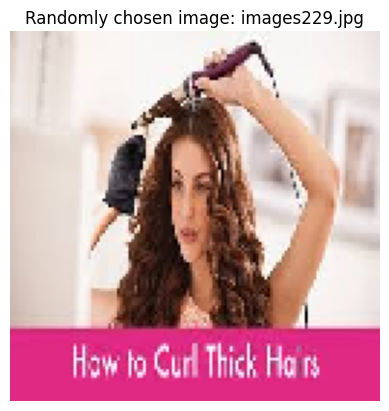

In [20]:
import os
import random
import matplotlib.pyplot as plt

folder_number = random.randint(1, 3)  
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)

image_path = os.path.join(dataset_dir, random_file)

img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

print(
    f"Random Image: {random_file}\n"
    f"Folder: {dataset_dir}\n"
    f"This image is Curly Hair: {predictions[0][0] * 100:.2f}%, "
    f"Straight Hair: {predictions[0][1] * 100:.2f}%, "
    f"Wavy Hair: {predictions[0][2] * 100:.2f}%."
)

plt.imshow(img)
plt.title("Randomly chosen image: " + random_file)
plt.axis("off")
plt.show()


### Overfit Plot Table

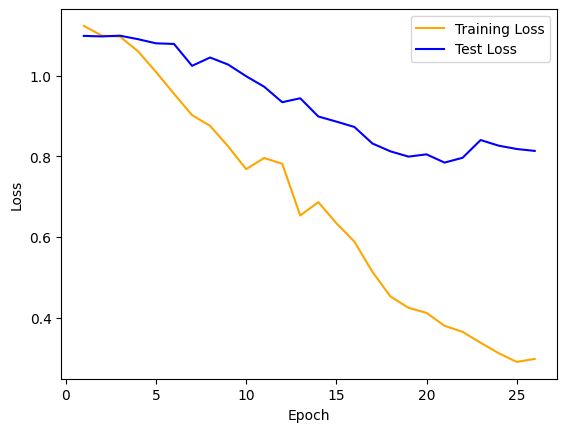

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, color="orange")
plt.plot(epoch_count, val_loss, color="blue")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

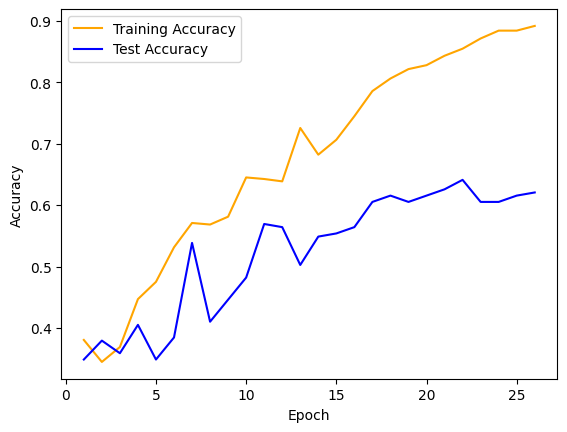

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_acc, color="orange")
plt.plot(epoch_count, val_acc, color="blue")
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();
